# Admixture data

In [1]:
import re, os, sys, math
from pathlib import Path
import numpy
import pandas
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

from GenomicWindows import window
import GenomicIntervals


### Analysis dirs

In [2]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
#pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

### Local code in the scripts dir on the cluster

In [3]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

### Plotting setup

In [4]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

In [5]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

numpy.random.seed(7)

# Load meta data

In [6]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

# Laurtis admixture data

Laurits decodeed a few Africans by mistake, so I need to filter to get only the Africans:

In [7]:
non_african_indiv = [i for i, d in individuals.items() if d['Region'] != 'Africa' and d['Genetic sex assignment'] == 'XY']

In [8]:
min_post_prop_cutoff = 0.8

male_x_admix_segments = (pandas.read_table(str(data_dir / 'laurits_data/RestofworldHMMHaploid_samePAR.txt'), 
                                          dtype={'chrom': str})
                         .loc[lambda df: df.name.isin(non_african_indiv)]
                         .loc[lambda df: df.MeanProb >= min_post_prop_cutoff]
                        )

male_x_admix_segments.snps.fillna('', inplace=True)
male_x_admix_segments.Altai.fillna('', inplace=True)
male_x_admix_segments.Denisova.fillna('', inplace=True)
male_x_admix_segments.Vindija.fillna('', inplace=True)

male_x_admix_segments['archaic_snps'] = [x[0] and len(x) or 0 for x in male_x_admix_segments.snps.str.split(',')]
male_x_admix_segments['altai_snps'] = [x[0] and len(x) or 0 for x in male_x_admix_segments.Altai.str.split(',')]
male_x_admix_segments['denisova_snps'] = [x[0] and len(x) or 0 for x in male_x_admix_segments.Denisova.str.split(',')]
male_x_admix_segments['vindija_snps'] = [x[0] and len(x) or 0 for x in male_x_admix_segments.Vindija.str.split(',')]

male_x_admix_segments.to_hdf(results_dir / 'male_x_admix_segments.hdf', 'df', format='table', mode='w')

print(len(male_x_admix_segments))
male_x_admix_segments.head()

1359


,name,chrom,start,end,length,state,snps,region,method,dataset,...,Altai,Denisova,Vindija,Denis,sex,LongestGap,archaic_snps,altai_snps,denisova_snps,vindija_snps
101,S_Brahui-2,X,20456000,20499000,43000,2,"20460465,20470345,20475029,20483946,20493226,2...",SouthAsia,HMM,Sankararaman2016,...,,,,SubAfrica,M,1,6,0,0,0
104,S_Brahui-2,X,40151000,40236000,85000,2,"40157757,40158481,40170041,40187117,40228851,4...",SouthAsia,HMM,Sankararaman2016,...,40187117,40187117,40187117,SubAfrica,M,4,6,1,1,1
105,S_Brahui-2,X,49535000,49616000,81000,2,"49541070,49552902,49559642,49580786,49594136,4...",SouthAsia,HMM,Sankararaman2016,...,,,,SubAfrica,M,5,8,0,0,0
106,S_Brahui-2,X,54940000,55102000,162000,2,"54948373,54950747,54976385,55026543,55034106,5...",SouthAsia,HMM,Sankararaman2016,...,,,,SubAfrica,M,8,9,0,0,0
107,S_Brahui-2,X,56228000,56329000,101000,2,"56241959,56257196,56271367,56291516,56296488,5...",SouthAsia,HMM,Sankararaman2016,...,,,,SubAfrica,M,5,6,0,0,0


In [9]:
len(set(male_x_admix_segments.name)), len(non_african_indiv)

(140, 140)

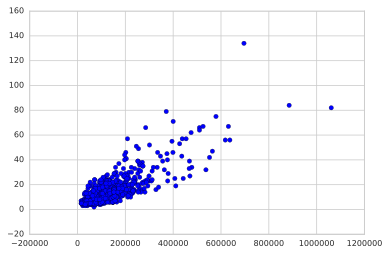

In [10]:
g = plt.scatter(male_x_admix_segments.length, male_x_admix_segments.archaic_snps)

In [11]:
male_x_admix_segments.loc[lambda df: (df.name == 'S_Papuan-10')].sort_values(by=['length'], ascending=False).head()

,name,chrom,start,end,length,state,snps,region,method,dataset,...,Altai,Denisova,Vindija,Denis,sex,LongestGap,archaic_snps,altai_snps,denisova_snps,vindija_snps
4723,S_Papuan-10,X,14642000,14954000,312000,2,"14647548,14650798,14653243,14657665,14665665,1...",Oceania,HMM,Sankararaman2016,...,"14653243,14657665,14694174,14698027,14719404,1...",,"14647548,14653243,14657665,14665665,14694174,1...",SubAfrica,M,5,31,16,0,26
4714,S_Papuan-10,X,4231000,4516000,285000,2,"4234674,4234737,4236148,4255989,4261908,426150...",Oceania,HMM,Sankararaman2016,...,"4234674,4236148,4359924,4377326,4379336,438917...","4234674,4236148,4262111,4264715,4293098,431456...","4234674,4236148,4359924,4377326,4379336,438917...",SubAfrica,M,6,66,10,18,11
4744,S_Papuan-10,X,100372000,100578000,206000,2,"100374226,100395569,100396158,100400872,100460...",Oceania,HMM,Sankararaman2016,...,"100374226,100396158,100400872,100472783,100477...","100501305,100503284,100538339","100374226,100395569,100396158,100400872,100470...",SubAfrica,M,8,19,11,3,14
4716,S_Papuan-10,X,5762000,5929000,167000,2,"5771479,5782709,5788371,5791119,5795410,582825...",Oceania,HMM,Sankararaman2016,...,,,,SubAfrica,M,0,17,0,0,0
4722,S_Papuan-10,X,13947000,14100000,153000,2,"13950724,13958152,13960603,13965821,13975537,1...",Oceania,HMM,Sankararaman2016,...,"13950724,13965821,13975537,14006751,14007932,1...","14006751,14048509","13950724,13958152,13965821,13975537,13981174,1...",SubAfrica,M,2,29,14,2,12


## Callability windows

In [12]:
admix_callability_windows = (pandas.read_table(str(data_dir / 'laurits_data/Callability_window_100000.txt'), 
                                      dtype={'chrom': str, 'start': int, 'end': int, 'round_pos': int})
                    .assign(start = lambda df:df.round_pos, 
                             end = lambda df:df.round_pos + 100000)
                    )
admix_callability_windows.head()

,round_pos,chrom,called,end,start
0,0,1,0.0,100000,0
1,0,10,0.0,100000,0
2,0,11,0.0,100000,0
3,0,12,0.0,100000,0
4,0,13,0.0,100000,0


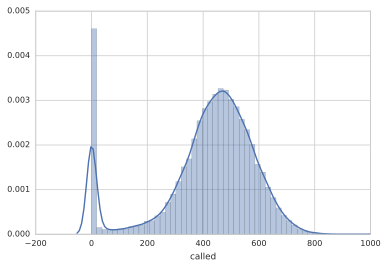

In [13]:
g = sns.distplot(admix_callability_windows.called)

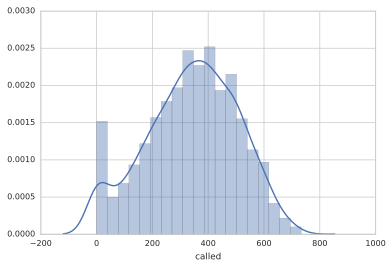

In [14]:
g = sns.distplot(admix_callability_windows.loc[lambda df: df.chrom == 'X', 'called'])

### By individual in 100kb windows

In [15]:
min_called_admix = 200

window_size = 100000
@window(size=window_size, fill={'nr_admix_tracts': 0, 'tot_admix_len': 0, 'admix_prop': 0,
                               'archaic_snps': 0, 'altai_snps': 0, 'denisova_snps': 0, 'vindija_snps': 0})
def stats(df):
    return {'nr_admix_tracts': df.start.count(), 
            'tot_admix_len': sum(df.end-df.start),
            'archaic_snps': df.archaic_snps.sum(),
            'altai_snps': df.altai_snps.sum(),
            'denisova_snps': df.denisova_snps.sum(),
            'vindija_snps': df.vindija_snps.sum(),
            'admix_prop': sum(df.end-df.start) / window_size}
                                   
df = (male_x_admix_segments.loc[lambda df: df.chrom == 'X']
                 .groupby(['chrom', 'name'])
                 .apply(stats)
                 .reset_index(level=['chrom', 'name'])
                )

male_x_admix_windows = df.merge(admix_callability_windows, on=['chrom', 'start', 'end'], how='left')

male_x_admix_windows.loc[lambda df: df.called < min_called_admix, 'admix_prop'] = numpy.nan
male_x_admix_windows.loc[lambda df: df.called < min_called_admix, 'archaic_snps'] = numpy.nan
male_x_admix_windows.loc[lambda df: df.called < min_called_admix, 'altai_snps'] = numpy.nan
male_x_admix_windows.loc[lambda df: df.called < min_called_admix, 'denisova_snps'] = numpy.nan
male_x_admix_windows.loc[lambda df: df.called < min_called_admix, 'vindija_snps'] = numpy.nan

male_x_admix_windows.head()

,chrom,name,start,end,tot_admix_len,denisova_snps,vindija_snps,admix_prop,archaic_snps,nr_admix_tracts,altai_snps,round_pos,called
0,X,B_Australian-4,0,100000,0,NaN,NaN,NaN,NaN,0,NaN,0,13.42
1,X,B_Australian-4,100000,200000,0,NaN,NaN,NaN,NaN,0,NaN,100000,50.69
2,X,B_Australian-4,200000,300000,0,NaN,NaN,NaN,NaN,0,NaN,200000,97.54
3,X,B_Australian-4,300000,400000,0,0.0,0.0,0.0,0.0,0,0.0,300000,267.62
4,X,B_Australian-4,400000,500000,0,0.0,0.0,0.0,0.0,0,0.0,400000,232.68


In [16]:
male_x_admix_windows.to_hdf(results_dir / 'male_x_admix_windows.hdf', 'df', format='table', mode='w')

Distribution of number of archaic SNPs in windows with such SNPs:

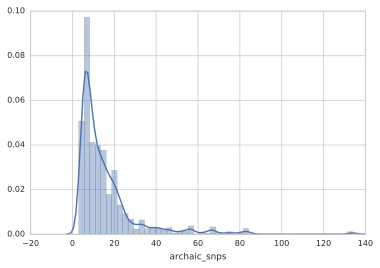

In [17]:
g = sns.distplot(male_x_admix_windows.loc[lambda df: numpy.bitwise_and(~numpy.isnan(df.archaic_snps),
                                                                       df.archaic_snps != 0)].archaic_snps)

1Mb means:

In [18]:
window_size = 1000000
@window(size=window_size, fill={'nr_admix_tracts': 0, 'tot_admix_len': 0, 'admix_prop': 0,
                               'archaic_snps': 0, 'altai_snps': 0, 'denisova_snps': 0, 'vindija_snps': 0})
def mb_means(df):
    return {'nr_admix_tracts': df.nr_admix_tracts.mean(), 
            'tot_admix_len': df.tot_admix_len.mean(), 
            'archaic_snps': df.archaic_snps.sum(),
            'altai_snps': df.altai_snps.sum(),
            'denisova_snps': df.denisova_snps.sum(),
            'vindija_snps': df.vindija_snps.sum(),
            'admix_prop': df.admix_prop.mean()}

cols = ['chrom', 'name']
male_x_admix_windows_1Mb = (male_x_admix_windows
                          .groupby(cols)
                          .apply(mb_means)
                          .reset_index(level=cols)
                          )

male_x_admix_windows_1Mb.to_hdf(results_dir / 'male_x_admix_windows_1Mb.hdf', 'df', format='table', mode='w')

In [19]:
male_x_admix_windows_1Mb.head()

,chrom,name,start,end,tot_admix_len,denisova_snps,vindija_snps,admix_prop,archaic_snps,nr_admix_tracts,altai_snps
0,X,B_Australian-4,0,1000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,X,B_Australian-4,1000000,2000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,X,B_Australian-4,2000000,3000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,X,B_Australian-4,3000000,4000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,X,B_Australian-4,4000000,5000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Amount of admixture

In [20]:
def get_region(df):
    regions = list()
    for name in df.name:
        if name in individuals:
            regions.append(individuals[name]['Region'])
        else:
            regions.append(numpy.nan)
    return regions
    
male_x_admix_windows.assign(region = get_region).groupby(['region']).mean()

,start,end,tot_admix_len,denisova_snps,vindija_snps,admix_prop,archaic_snps,nr_admix_tracts,altai_snps,round_pos,called
region,,,,,,,,,,,
America,6.797251e+07,6.807251e+07,576.813790,0.015257,0.062710,0.006959,0.184286,0.012881,0.049375,6.797251e+07,338.191577
CentralAsiaSiberia,6.953904e+07,6.963904e+07,473.568443,0.004616,0.020401,0.005508,0.125912,0.010338,0.020770,6.953904e+07,341.082036
EastAsia,7.095566e+07,7.105566e+07,776.528908,0.018038,0.097414,0.009272,0.272872,0.015110,0.081705,7.095566e+07,340.545994
Oceania,7.386395e+07,7.396395e+07,1254.266791,0.107509,0.168214,0.015133,0.556752,0.023648,0.141894,7.386395e+07,341.720695
SouthAsia,7.120904e+07,7.130904e+07,801.553589,0.037446,0.119242,0.009253,0.291658,0.015888,0.094544,7.120904e+07,340.134548
WestEurasia,6.432432e+07,6.442432e+07,698.551921,0.016966,0.066342,0.008227,0.226159,0.013707,0.054156,6.432432e+07,340.833970


## Archaic SNPs in windows along chromosome

For each window we need to know how many differences between male haplogypes are due to archiac snps. We want to be ale to filter them out to make sure it does not inflate estimated diffs in a way that makes unable to call sweeps in regions with admxiture.

Read all snp positions:

In [21]:
from collections import defaultdict

groups = male_x_admix_segments.groupby('name')

archaic_snps = defaultdict(set)
for indiv, group in groups:
    for tup in group.itertuples():
        one_based = [int(x) for x in tup.snps.split(',') if x]
        zero_based = [x-1 for x in one_based]
        archaic_snps[indiv].update(zero_based)

In [22]:
import pyfaidx

file_index = dict()
for file_path in male_x_haploid_dir.glob('*.fa'):
    name = file_path.name.split('.')[0]
    file_index[name] = pyfaidx.Fasta(str(file_path), 
                                     strict_bounds=True, 
                                     one_based_attributes=False)

In [23]:
archaic_snps_by_indiv = None

male_indivs = list()
for indiv in male_x_admix_segments.name.unique():
    print(individuals[indiv]['Genetic sex assignment'])
    if individuals[indiv]['Genetic sex assignment'] == 'XY':
        male_indivs.append(indiv)

for indiv in male_indivs:    
    snps = archaic_snps[indiv]
    assert snps

#    indiv += '-A' ### Make table with indiv names without -A ......
    chrom = file_index[indiv + '-A']['X'][:].seq    
        
    bases = [chrom[pos] for pos in snps]
    df = pandas.DataFrame().from_records(zip(snps, bases), columns=['pos', 'base'])
    df[indiv] = True

    if archaic_snps_by_indiv is None:
        archaic_snps_by_indiv = df
    else:
        archaic_snps_by_indiv = archaic_snps_by_indiv.merge(df, on=['pos', 'base'], how='outer')
    
archaic_snps_by_indiv = archaic_snps_by_indiv.fillna(False)

XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY
XY


In [24]:
archaic_snps_by_indiv.head()

,pos,base,S_Brahui-2,S_Finnish-3,S_Karitiana-1,S_Burusho-1,S_She-2,S_Armenian-2,S_Tu-1,S_Chane-1,...,S_North_Ossetian-1,S_Georgian-1,B_Sardinian-3,S_Han-2,S_Papuan-4,S_Yadava-1,S_Hazara-2,S_French-1,S_Greek-2,S_Iranian-1
0,49552901,G,True,False,False,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
1,56271366,C,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,55083017,C,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,54948372,G,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,40231463,A,True,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


Make sure there are at most one one ref and one alternative base for each position:

In [25]:
archaic_snps_by_indiv.loc[lambda df: df.base != 'N'].groupby(['pos'])['base'].count().unique()

array([1, 2])

Add all snps called in one individual to all indivisuals:

In [26]:
all_pos = archaic_snps_by_indiv.pos
all_bases = archaic_snps_by_indiv.base

archaic_snps_by_indiv.set_index(['pos', 'base'], inplace=True)

for indiv in male_indivs: 
    chrom = file_index[indiv + '-A']['X'][:].seq

    for pos, base in zip(all_pos, all_bases):
        if base != 'N' and chrom[pos] == base:
            archaic_snps_by_indiv.loc[(pos, base), indiv] = True

archaic_snps_by_indiv.reset_index(inplace=True)

Compute the number of archaic SNPs in windows:

In [28]:
def archaic_snp_counts_in_windows(binsize):

    chrom_size = chromosome_lengths['X']
    cuts = list(range(0, chrom_size+1, binsize))

    pair_list = list()
    for indiv_1 in male_indivs:
        for indiv_2 in male_indivs:
            if indiv_1 == indiv_2:
                continue

            snp_set1 = set(archaic_snps_by_indiv.loc[archaic_snps_by_indiv[indiv_1]].pos)
            snp_set2 = set(archaic_snps_by_indiv.loc[archaic_snps_by_indiv[indiv_2]].pos)
            
            archaic_het_sites = sorted(snp_set1.symmetric_difference(snp_set2))
            
            bin_starts = pandas.cut(archaic_het_sites, bins=cuts, labels=cuts[:-1], right=False)
            df = DataFrame({'indiv_1': indiv_1, 
                            'indiv_2': indiv_2, 
                            'start': bin_starts, 
                            'archaic_hets': archaic_het_sites})
            df = df.groupby(['indiv_1', 'indiv_2', 'start']).count().reset_index()
            pair_list.append(df)

    return pandas.concat(pair_list)

In [29]:
archaic_snp_counts = archaic_snp_counts_in_windows(100000)
archaic_snp_counts.to_hdf(results_dir / 'archaic_snp_counts.hdf', 'df', format='table', mode='w')
archaic_snp_counts.head()

,indiv_1,indiv_2,start,archaic_hets
0,S_Brahui-2,S_Finnish-3,0,NaN
1,S_Brahui-2,S_Finnish-3,100000,NaN
2,S_Brahui-2,S_Finnish-3,200000,NaN
3,S_Brahui-2,S_Finnish-3,300000,NaN
4,S_Brahui-2,S_Finnish-3,400000,NaN


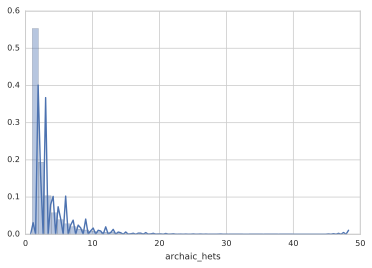

In [30]:
g = sns.distplot(archaic_snp_counts.archaic_hets.loc[archaic_snp_counts.archaic_hets > 0])

In [31]:
archaic_snp_counts_1Mb = archaic_snp_counts_in_windows(1000000)
archaic_snp_counts_1Mb.to_hdf(results_dir / 'archaic_snp_counts_1Mb.hdf', 'df', format='table', mode='w')
archaic_snp_counts_1Mb.head()

,indiv_1,indiv_2,start,archaic_hets
0,S_Brahui-2,S_Finnish-3,0,NaN
1,S_Brahui-2,S_Finnish-3,1000000,NaN
2,S_Brahui-2,S_Finnish-3,2000000,NaN
3,S_Brahui-2,S_Finnish-3,3000000,NaN
4,S_Brahui-2,S_Finnish-3,4000000,1.0


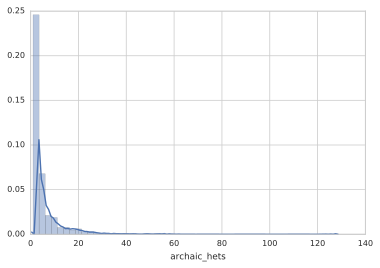

In [32]:
g = sns.distplot(archaic_snp_counts_1Mb.archaic_hets.loc[archaic_snp_counts_1Mb.archaic_hets > 0])